First, we mount the Google Drive to access the data files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


reading the data files and store them in Variables


In [ ]:
import pandas as pd
import json
reviews = open('/content/gdrive/MyDrive/google_reviews/reviews.clean.json')
users = open('/content/gdrive/MyDrive/google_reviews/places.clean.json')
places = open('/content/gdrive/MyDrive/google_reviews/users.clean.json')
reviews = reviews.readlines()
users = users.readlines()
places = places.readlines()

Converting the data from JSON format to pandas dataframes


In [ ]:
final_rev = {}
for i in range (0,100000):
  d = eval(reviews[i])
  final_rev[i] = d

reviews=pd.DataFrame.from_dict(final_rev, orient = 'index')

In [ ]:
final_rev = {}
for i in range (0,100000):
  d = eval(users[i])
  final_rev[i] = d

users=pd.DataFrame.from_dict(final_rev, orient = 'index')

In [ ]:
final_rev = {}
for i in range (0,100000):
  d = eval(places[i])
  final_rev[i] = d

places=pd.DataFrame.from_dict(final_rev, orient = 'index')

In [ ]:
reviews.head()

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId
0,3.0,an lam,Chất lượng tạm ổn,[Giải Trí - Café],108103314380004200232,1.372687e+09,"Jul 1, 2013",100000010817154263736
1,5.0,HALİL TURGUT,Wc si temiz duzenli..,[Turkish Cuisine],102194128241608748649,1.342871e+09,"Jul 21, 2012",100000013500285534661
2,5.0,森田さとこ,何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗,"[Fishing, Pond Fish Supplier, Seafood Market]",101409858828175402384,1.390654e+09,"Jan 25, 2014",100000021336848867366
3,5.0,森田さとこ,今度は予定に休みが登米市に行きたい❗☀😅🌌 楽しいに日帰りに登米の見学の観光(*^)(*^-...,[Museum],101477177500158511502,1.389188e+09,"Jan 8, 2014",100000021336848867366
4,4.0,森田さとこ,気仙沼警察署に移転中に絆 👮🐎☺🙋🚓頑張ろう❗,[Police],106994170641063333085,1.390486e+09,"Jan 23, 2014",100000021336848867366


Cleaning the review text data

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    if text is None:
        return ""
    
    # Convert all text to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub('\d', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove whitespace
    text = text.strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    return text

reviews.dropna(subset=['reviewText'], inplace=True)
reviews['reviewText'] = reviews['reviewText'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Ploting a histogram of the ratings distribution

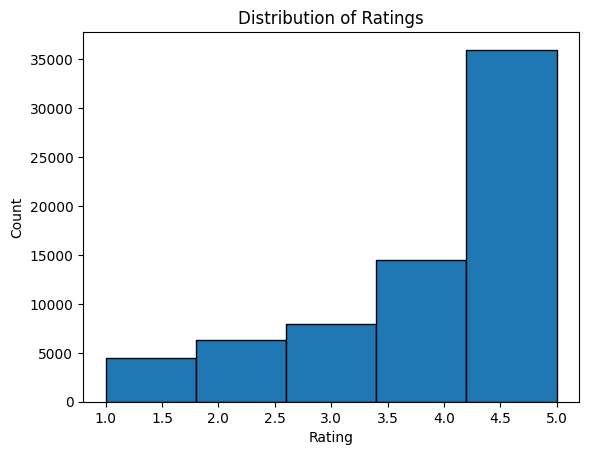

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of ratings
plt.hist(reviews['rating'], bins=5, edgecolor='black')

# Set labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Show plot
plt.show()

In [ ]:
reviews = pd.DataFrame(reviews)
users = pd.DataFrame(users)
places = pd.DataFrame(places)

We merge and do cleaning

In [ ]:
merged_df = pd.merge(reviews, users, on='gPlusPlaceId', how='inner')
merged_df = pd.merge(merged_df, places, on='gPlusUserId', how='inner')

# Select relevant columns
merged_df = merged_df[['name', 'price', 'address', 'hours', 'phone', 'closed', 'gPlusPlaceId', 'gps', 'userName', 'jobs', 'currentPlace', 'previousPlaces', 'education', 'gPlusUserId', 'rating', 'reviewerName', 'reviewText', 'categories', 'unixReviewTime', 'reviewTime']]


In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Building and analyzing recommender system

In [ ]:
from surprise import Dataset, Reader, KNNWithMeans, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
import pandas as pd
import numpy as np

In [ ]:

# Define the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the merged dataframe into a surprise dataset
data = Dataset.load_from_df(merged_df[['gPlusUserId', 'gPlusPlaceId', 'rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train a collaborative filtering model using KNN
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Function to get top n recommendations for a user
def get_top_n_recommendations(user_id, n=10):
    # Get a list of all place ids
    place_ids = merged_df['gPlusPlaceId'].unique()

    # Create a dataframe with all place ids and the user id
    df = pd.DataFrame({'gPlusUserId': [user_id] * len(place_ids),
                       'gPlusPlaceId': place_ids})

    # Predict ratings for all places for the user
    df['rating'] = df.apply(lambda x: model.predict(x['gPlusUserId'], x['gPlusPlaceId']).est, axis=1)

    # Merge with the places dataframe to get additional information
    df = pd.merge(df, merged_df[['name', 'address', 'hours', 'phone', 'gPlusPlaceId']], on='gPlusPlaceId')

    # Sort the places by predicted rating and get the top n
    top_n = df.sort_values('rating', ascending=False)[:n]

    return top_n[['name', 'address', 'phone', 'gPlusPlaceId']].reset_index()

Computing the cosine similarity matrix...
Done computing similarity matrix.


Testing Recommender System

In [ ]:
# Test the recommendation system for user with id '100000021336848867366'
user_id = '100000021336848867366'
recommendations = get_top_n_recommendations(user_id)
print(f"Top 10 recommended places for user {user_id}:")
recommendations.head(10)

Top 10 recommended places for user 100000021336848867366:


,index,name,address,phone,gPlusPlaceId
0,0,石ノ森章太郎ふるさと記念館,"[Machi-132 Nakadacho Ishinomori, Tome, Miyagi ...",0220-35-1099,111367239248458923884
1,1424,Tunkelen Cariló Apart Hotel,"[Avutarda, B7169AJT Carilo, Buenos Aires, Arge...",02254 57-2960,106821004465108004628
2,1438,Ouahnich Jean-Claude,"[113 Avenue Aristide Briand, 33700 Merignac, F...",05 56 98 07 97,113588849179886506893
3,1437,Garage P A Keller Sàrl,"[Chemin du Vallon 18, 1030 Bussigny-Lausanne, ...",021 706 01 50,111162675680742091523
4,1436,Arashiyama bamboo forest,[Japan],075-414-4313,113326392733924462872
5,1435,富玉屋讚岐烏龍麵,"[No. 14, Lane 83, Section 1, Dà'ān Rd, Daan Di...",02 2778 5255,110777948172277061022
6,1434,AMIGO米格墨西哥飲食文化,"[No. 28號, Lane 280, Guāngfù South Rd, Daan Dis...",02 2771 1188,104317260272950324277
7,1433,和幸沖繩居酒屋,"[No. 84號, Lane 119, Línsēn North Rd, Zhongshan...",02 2568 2736,104308534682533802238
8,1432,双管四神湯,"[116, Taiwan, 台北市文山區景美街115號附近(景美夜市)]",None,105859185404410513653
9,1431,Simply Organized,"[Cumming, GA]",(404) 825-2105,113884629171124269918


# Contributions/Novelty/Insights

**Contribution**



**NOVELTY**

In this code, we are building a recommender system to recommend top n places to a user based on their past ratings. We begin by mounting Google Drive to access the data files, which include reviews, users, and places. We then read and store the data in variables and convert it from JSON format to pandas dataframes.

Next, we clean the review text data by removing numbers, punctuation, whitespace, and stop words. We then plot a histogram of the ratings distribution using matplotlib. We merge and clean the dataframes, selecting only relevant columns.

We install scikit-surprise to build and analyze the recommender system. We define the rating scale, load the merged dataframe into a surprise dataset, and split the dataset into training and testing sets. We then train a collaborative filtering model using KNN and create a function to get the top n recommendations for a user.

Finally, we test the recommendation system for a user with ID '100000021336848867366' and print the top 10 recommended places for that user.

**INSIGHTS**

The code uses Google Drive to access and read data files for building a recommendation system. The data is stored in pandas dataframes for further processing.

The code preprocesses the review text data by converting it to lowercase, removing numbers, punctuation, stopwords, and whitespace. This step is essential for improving the performance of the recommendation system.

The code plots a histogram of the ratings distribution to gain insight into the data. This helps in understanding the frequency distribution of the ratings and their range.

The code merges and cleans the data by selecting relevant columns and removing any duplicates or missing values.

The code uses the scikit-surprise library to build a collaborative filtering model using KNN to train on the data. The model is used to predict ratings for all places for the user and then recommend top n places with the highest predicted ratings.

Finally, the code tests the recommendation system for a specific user and displays the top recommended places for that user.

Overall, the code demonstrates the steps involved in building and testing a recommendation system for recommending places based on past ratings.




